<a href="https://colab.research.google.com/github/AdilRaheem/Air-Quality-Pediction/blob/main/Air_Quality_Dar_es_Salaam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

In [6]:
df1 = pd.read_csv('/content/drive/MyDrive/WorldQuant DS Practice/Air quality/august_2018_sensor_data_archive.csv', low_memory=False)
df2 = pd.read_csv('/content/drive/MyDrive/WorldQuant DS Practice/Air quality/september_2018_sensor_data_archive.csv', low_memory=False)
#df3= pd.read_csv('july_2018_sensor_data_archive.csv', low_memory=False)

In [ ]:
df = pd.concat([df1,df2])

In [ ]:
df.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,29,SDS011,22,-6.902,39.267,2018-08-01T05:16:30.336309+00:00,P2,36.27
1,29,SDS011,22,-6.902,39.267,2018-08-01T05:16:30.336309+00:00,P1,97.27
2,29,SDS011,22,-6.902,39.267,2018-08-01T05:19:35.336800+00:00,P1,103.57
3,29,SDS011,22,-6.902,39.267,2018-08-01T05:19:35.336800+00:00,P2,36.37
4,29,SDS011,22,-6.902,39.267,2018-08-01T05:22:37.380210+00:00,P2,47.57


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346502 entries, 0 to 226929
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sensor_id    346502 non-null  int64  
 1   sensor_type  346502 non-null  object 
 2   location     346502 non-null  int64  
 3   lat          346502 non-null  float64
 4   lon          346502 non-null  float64
 5   timestamp    346502 non-null  object 
 6   value_type   346502 non-null  object 
 7   value        346502 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 23.8+ MB


## Data Wrangling

In [ ]:
def wrangle(df):
    
    #mask P2 readings
    mask_p2 = df['value_type'] == 'P2'
    
    #mask location
    mask_loc = df['location'] == 11
    
    df = df[mask_p2 & mask_loc].copy()
    
    #drop columns
    df.drop(columns = ['sensor_id', 'sensor_type', 'location','lat','lon','value_type'], inplace=True)
    
    #change timestamp datatype to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    #set timestamp as index
    df = df.set_index('timestamp')
    
    #set timezone
    df.index = df.index.tz_convert('Africa/Dar_es_Salaam')
    
    #convert value datatype to float
    df['value'] = df['value'].astype(float)
    
    #resample dataframe
    y =df['value'].resample('1H').mean().fillna(method = 'ffill')
    
    return y
    

When dealing with time series data it is usually more appropirate to use a series than a dataframe. Hence why the data is left in series form

In [ ]:
data = wrangle(df)

In [ ]:
data.head()

timestamp
2018-08-03 19:00:00+03:00    7.049000
2018-08-03 20:00:00+03:00    6.450417
2018-08-03 21:00:00+03:00    6.443750
2018-08-03 22:00:00+03:00    6.398333
2018-08-03 23:00:00+03:00    7.216250
Freq: H, Name: value, dtype: float64

## Data Exploration

Text(0.5, 1.0, 'Dar es Salaam PM2.5 Levels')

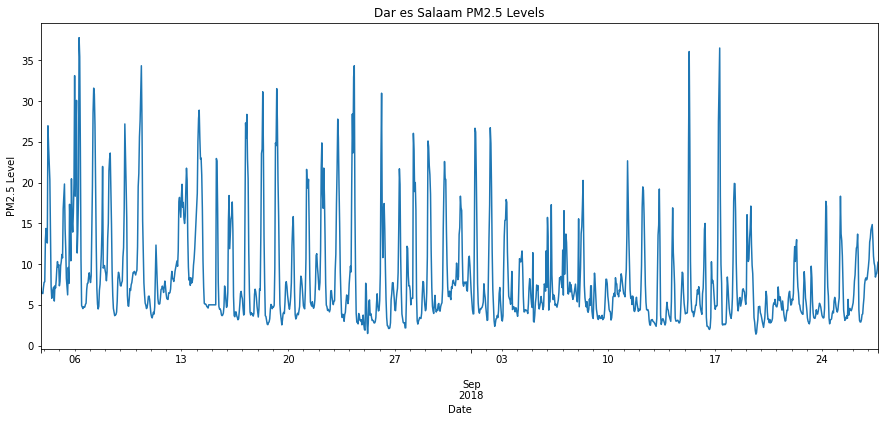

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
data.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('PM2.5 Level')
plt.title('Dar es Salaam PM2.5 Levels')

Text(0.5, 1.0, '7-Day Rolling Average of PM 2.5 levels (Dar-es-Salaam)')

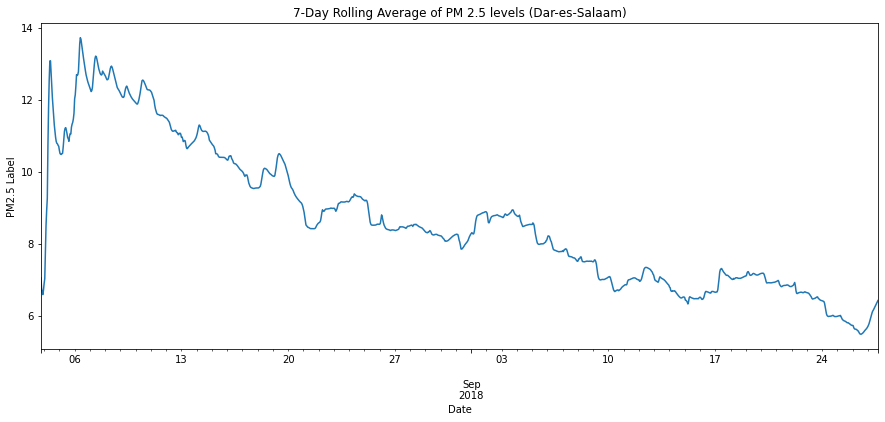

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
data.rolling('168H').mean().plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('PM2.5 Label')
plt.title('7-Day Rolling Average of PM 2.5 levels (Dar-es-Salaam)')

### Autocorrelation plot<br>
Autocorrelation involves taking data from one part of a set and comparing it to another part. An Auto-Correlation Function (ACF) plot is a visual representation of an autocorrelation function.

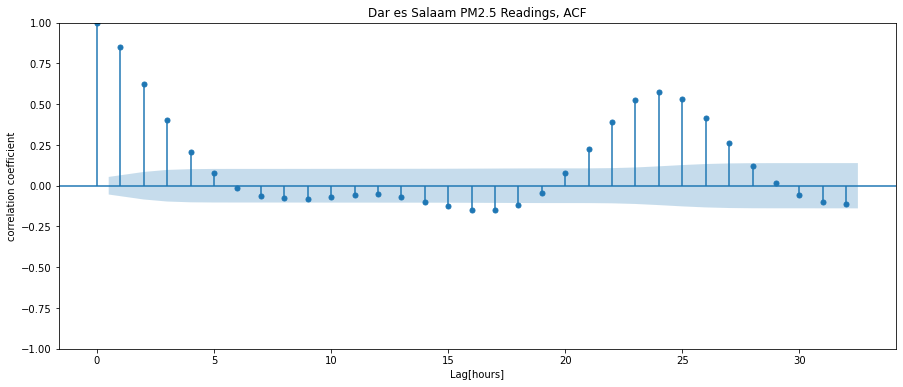

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(data, ax=ax)
plt.xlabel('Lag[hours]')
plt.ylabel('correlation coefficient')
plt.title('Dar es Salaam PM2.5 Readings, ACF');

There is strong predictive power in the first four hours. The predictive power trends downwards with increase in lag. There is however another peak at 24 hour mark, indicating that what happened 24 hours ago has some predictive power on the present .<br>

The blue band indicates that anything within it has a very small correlation that it is statistically insignificant, therefore, we are only interested in values outside the band.


In [ ]:
#correlation between 1 hour in the past and 2 hours in the past
data.shift(1).corr(data.shift(2))

0.8508678264817081

In [ ]:
#correlation between 3 hours in the past and 4 hours in the past
data.shift(3).corr(data.shift(4))

0.8508686240605957

It can be seen that there's a strong correlation between what happened at a point (now) and an hour ago and that the correlation value is infact the same thing at any point in time and an hour before that time. This regarded as an echo.
This one hour correlation echoes through to the different lags in the ACF plot. Because of this, we wil not be using this plot to determine how many lags we want for our model.

We will use the Partial Auto-Correlation Function(PACF) plot instead. Partial autocorrelation is an autocorrelation that only includes the direct observations. when viewed as fUnction, it is called PACF. The PACF plot will remove that echo and let us know which lags actually have that strong predictive power.

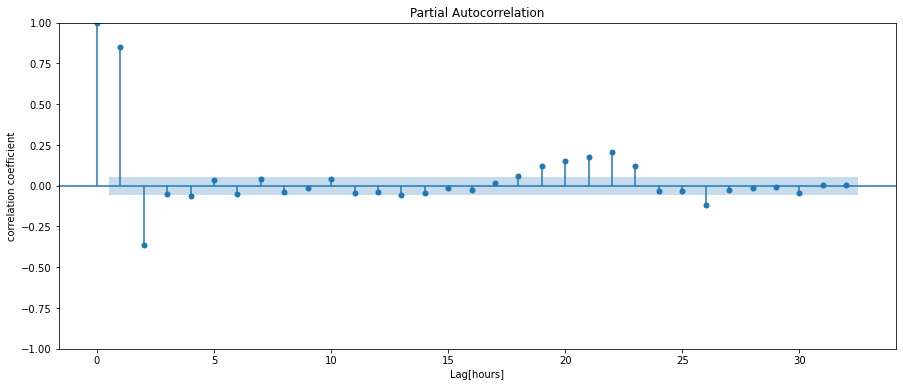

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(data, ax=ax, method='ywm')
plt.xlabel('Lag[hours]')
plt.ylabel('correlation coefficient')
plt.title('Dar es Salaam PM2.5 Readings, PACF');

When compared to the ACF plot, The predictive power can be seen to be much smaller beyond the 3rd hour mark after we eliminated that 1 hour lag echo. 
It can be seen that for lags between 4 to 16, we realy don't have that predictive power but there is an uptrend wave of some predictive power after 16 up until 26.<br>
Generally beyond lag of 26, there isn't any predictive power left . For our AR model terefore, we therefore won't be considering anything beyond the lag of 26.

## Split Data

In [ ]:
cutoff_test = int(len(data) * 0.8)
y_train = data.iloc[:cutoff_test]
y_test = data.iloc[cutoff_test: ]
print('y_train shape: ', y_train.shape)
print('y_test: ', y_test.shape)

y_train shape:  (1054,)
y_test:  (264,)


## Build Model

### Baseline

In [ ]:
y_train_mean  = y_train.mean()
y_pred_train = len(y_train) * [y_train_mean]
mae_baseline = mean_absolute_error(y_train, y_pred_train )

print("Mean P2 Reading:", y_train_mean)
print('Baseline MAE: ', mae_baseline)

Mean P2 Reading: 8.806038846604501
Baseline MAE:  4.823471514289725


### Iterate

Our lag is our hyperparameter but we don't know  which hyperparameter settings will give the best performance.
We therefore employ the use of a for loop to train the Auto Regressive model on using settings for p from 1 to 26.

In [ ]:
p_params = range(1, 27)
maes = []

for p in p_params:
    
    model = AutoReg(y_train, lags=p).fit()
    y_pred = model.predict().dropna()
    mae = mean_absolute_error(y_train[p:], y_pred)
    maes.append(mae)

mae_series = pd.Series(maes, name='mae', index = p_params)
mae_series

1     2.089359
2     1.912345
3     1.910336
4     1.913019
5     1.917022
6     1.913669
7     1.920432
8     1.915731
9     1.915618
10    1.913367
11    1.921482
12    1.904339
13    1.905839
14    1.899858
15    1.897705
16    1.892297
17    1.891608
18    1.886722
19    1.882469
20    1.860969
21    1.815351
22    1.775656
23    1.764706
24    1.764111
25    1.757972
26    1.736496
Name: mae, dtype: float64

In [ ]:
mae_series.min()

1.7364959132066022

In [ ]:
best_p = 26
best_model = AutoReg(y_train, lags=best_p).fit()

###  Residuals
A residual is the vertical distance hetween each individual data point and the regression line. With linear models, you need to check and see what the residuals are for your model.

In [ ]:
y_train_resid = best_model.resid
y_train_resid.head()

timestamp
2018-08-04 21:00:00+03:00    1.650389
2018-08-04 22:00:00+03:00   -0.106428
2018-08-04 23:00:00+03:00    1.381167
2018-08-05 00:00:00+03:00   -1.676298
2018-08-05 01:00:00+03:00    0.094037
Freq: H, dtype: float64

<AxesSubplot:xlabel='timestamp'>

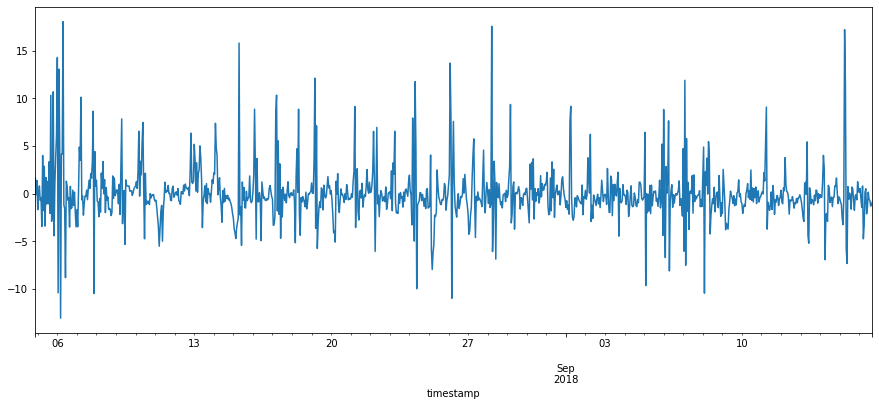

In [ ]:
fig,ax = plt.subplots(figsize=(15,6))
y_train_resid.plot(ax=ax)

The plot shows the the difference between our estimate and the true value on the y-axis. As we move up the axis, it shows how much under-estimated the values while the values down the axis are those that were over-estimated.<br>
 
There is no particular trend to these residual time series and it's centred around zero, this is a good indication that there is no trend in the time series data that our model is missing

We need to look at the distribution of these residuals and we want to make sure they are normally distributed

Text(0.5, 1.0, 'Best Model, Training Residuals')

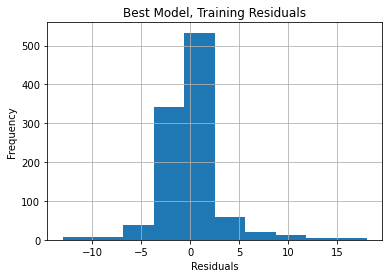

In [ ]:
y_train_resid.hist()
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Best Model, Training Residuals')

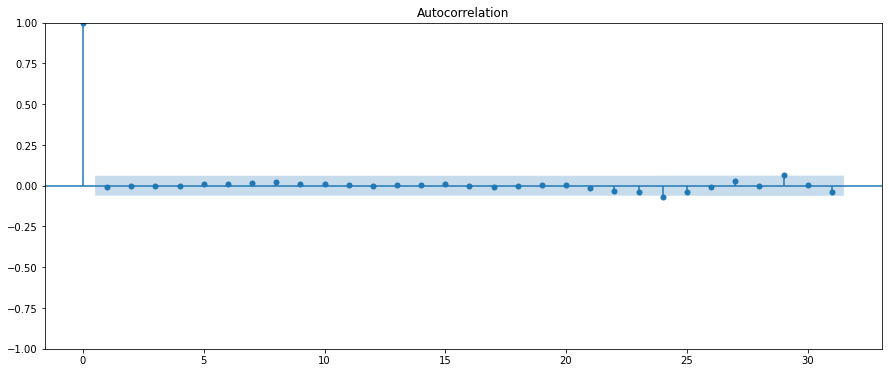

In [ ]:
fig,ax = plt.subplots(figsize=(15,6))
plot_acf(y_train_resid, ax=ax);

We can see that there is no way to predict a residual at a given time step from a previous time step. This indicates that our model has pulled all the predictive power out of the data during training. We then move on to evaluate our model using the test data

### Evaluate

The evaluation is carried out using walk-forward validation

In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=26).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
    pass
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

C:\Users\ADIL\Anaconda32\envs\my_environment\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


timestamp
2018-09-16 17:00:00+03:00     3.286240
2018-09-16 18:00:00+03:00     5.144785
2018-09-16 19:00:00+03:00    11.806078
2018-09-16 20:00:00+03:00     6.989316
2018-09-16 21:00:00+03:00     8.483240
Freq: H, Name: prediction, dtype: float64

In [ ]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print('Test MAE: ', test_mae)

Test MAE:  1.2232486449687388


## Results

In [ ]:
df_test = pd.DataFrame({'y_test': y_test, 'y_pred_wfv': y_pred_wfv})

fig = px.line(df_test)
fig.update_layout(
    title= 'Dar-es-salaam, Walk-forward validation Predictions',
    xaxis_title = 'Date',
    yaxis_title= 'PM2.5 level'   
)
fig.show()